In [2]:
# Graph Neural Network (GNN) for Molecular Energy Prediction
# code for building a flexible Graph Neural Network (GNN) to predict molecular energies based on atomic structures. 
#The GNN takes into account the interactions between atoms and their distances.

In [134]:
import torch.nn as nn
import torch.optim as optim
import random
from ase import Atoms
import numpy as np
import torch

# Function to build the graph
def build_graph(atoms, cutoff=5.0):
    # Compute distances between atoms
    distances = atoms.get_all_distances()
    
    # Get atomic numbers and reshape for concatenation
    atomic_numbers = atoms.get_atomic_numbers().reshape(-1, 1).astype(float)
    
    # Concatenate atomic numbers and distances as features
    features = np.hstack([atomic_numbers, distances])
    
    # Create adjacency matrix: 1 if distance is below cutoff, 0 otherwise (and set diagonal to 0)
    adjacency_matrix = (distances < cutoff).astype(float)
    np.fill_diagonal(adjacency_matrix, 0)
    
    return torch.tensor(features, dtype=torch.float32), torch.tensor(adjacency_matrix, dtype=torch.float32)

# Define the flexible Graph Neural Network (GNN) class
class FlexibleGNN(nn.Module):
    def __init__(self, input_dim, layers):
        super(FlexibleGNN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Add linear layers with ReLU activation functions
        last_dim = input_dim
        for layer_dim in layers:
            self.layers.append(nn.Linear(last_dim, layer_dim))
            last_dim = layer_dim
        
        # Output layer: predicting energy (single scalar)
        self.out_layer = nn.Linear(last_dim, 1)

    # Forward pass through the network
    def forward(self, x, adj_matrix):
        for layer in self.layers:
            x = torch.matmul(adj_matrix, x)
            x = nn.ReLU()(layer(x))  # Apply ReLU activation function
        # Output layer
        x = self.out_layer(x)
        return x

# Function to compute energies, I do this to a cheap way to compute energies but you can use DFT or import your own function like interatomic potentia
def compute_energy(atoms, cutoff=5.0):
    """
    This function calculates the total energy of a system of atoms as the sum of individual interaction energies.
    The interaction energy between any two atoms is defined by the product of their atomic numbers, the sine of the distance between them, and the inverse of the distance itself.
    
    Parameters:
    - atoms (ase.Atoms): The atomic configuration for which energies are to be computed.
    - cutoff (float): The maximum distance between atoms for which interactions are considered.
    
    Returns:
    - np.ndarray: The total energy of each atom in the system.
    """
    
    # Compute distances between all pairs of atoms
    distances = atoms.get_all_distances()
    
    # Get atomic numbers and reshape for broadcasting in interaction calculation
    atomic_numbers = atoms.get_atomic_numbers()
    Z1 = atomic_numbers.reshape(-1, 1)
    Z2 = atomic_numbers.reshape(1, -1)
    
    # Compute interaction values using the formula: Z1 * Z2 * sin(distance) / distance
    # This formula assumes that the interaction energy is proportional to the product of atomic numbers
    # and modulated by the sine of the distance between atoms, decaying with distance.
    interaction_values = Z1 * Z2 * np.sin(distances) / distances

    # Set the diagonal to zero to exclude self-interactions
    np.fill_diagonal(interaction_values, 0)
    
    # Sum the interaction values for each atom, considering only interactions within the cutoff distance
    energies = np.sum(np.where(distances < cutoff, interaction_values, 0), axis=1)
    
    return energies


Epoch 942/1100, Loss: 4.660713808611035, Learning rate: 6.553600000000004e-06
Epoch 943/1100, Loss: 4.658739050850272, Learning rate: 6.553600000000004e-06
Epoch 944/1100, Loss: 4.662000665441155, Learning rate: 6.553600000000004e-06
Epoch 945/1100, Loss: 4.658271254971623, Learning rate: 6.553600000000004e-06
Epoch 946/1100, Loss: 4.65961697883904, Learning rate: 6.553600000000004e-06
Epoch 947/1100, Loss: 4.65872055478394, Learning rate: 6.553600000000004e-06
Epoch 948/1100, Loss: 4.658073319122195, Learning rate: 6.553600000000004e-06
Epoch 949/1100, Loss: 4.658656815066934, Learning rate: 6.553600000000004e-06
Epoch 950/1100, Loss: 4.658358819782734, Learning rate: 6.553600000000004e-06
Epoch 951/1100, Loss: 4.657384280115366, Learning rate: 6.553600000000004e-06
Epoch 952/1100, Loss: 4.657511321827769, Learning rate: 6.553600000000004e-06
Epoch 953/1100, Loss: 4.657438246533275, Learning rate: 6.553600000000004e-06
Epoch 954/1100, Loss: 4.656870720908046, Learning rate: 6.55360000

Epoch 1048/1100, Loss: 4.634504439309239, Learning rate: 2.6214400000000015e-06
Epoch 1049/1100, Loss: 4.634416464716196, Learning rate: 2.6214400000000015e-06
Epoch 1050/1100, Loss: 4.634414141997695, Learning rate: 2.6214400000000015e-06
Epoch 1051/1100, Loss: 4.634315814822912, Learning rate: 2.6214400000000015e-06
Epoch 1052/1100, Loss: 4.634254455566406, Learning rate: 2.6214400000000015e-06
Epoch 1053/1100, Loss: 4.634232206270099, Learning rate: 2.6214400000000015e-06
Epoch 1054/1100, Loss: 4.633985817432404, Learning rate: 2.6214400000000015e-06
Epoch 1055/1100, Loss: 4.634037617594004, Learning rate: 2.6214400000000015e-06
Epoch 1056/1100, Loss: 4.633866725489497, Learning rate: 2.6214400000000015e-06
Epoch 1057/1100, Loss: 4.634147219359875, Learning rate: 2.6214400000000015e-06
Epoch 1058/1100, Loss: 4.634324133396149, Learning rate: 2.6214400000000015e-06
Epoch 1059/1100, Loss: 4.6335359942168, Learning rate: 2.6214400000000015e-06
Epoch 1060/1100, Loss: 4.633977131918073, 

In [115]:
# Constructing a dataset, you can import your own dataset in a .traj file
#The following code comments explain the process of constructing a dataset of atomic configurations by randomly perturbing
#the positions of a H2O2 molecule. The shake_positions function introduces randomness to simulate different possible states of the molecule. 
#These configurations are stored in a trajectory list, which can be used as a training set for computational simulations or machine learning models. 

from ase import Atoms
import numpy as np

# Function to shake atom positions
def shake_positions(positions, scale=0.1):
    """
    This function applies a random displacement to atom positions to simulate thermal motion or other perturbations.
    
    Parameters:
    - positions (np.ndarray): The original positions of the atoms.
    - scale (float): The standard deviation of the displacement applied to each coordinate.
    
    Returns:
    - np.ndarray: The new positions of the atoms after applying the random displacement.
    """
    return positions + np.random.normal(scale=scale, size=positions.shape)

# Initial positions for H2O2 molecule
initial_positions = [
    [0, 0, 0],  # First hydrogen atom
    [0, 0, 1],  # Second hydrogen atom
    [0, 1, 0],  # Oxygen atom
    [1, 0, 0]   # Second oxygen atom
]

# Number of steps to generate configurations for the training set
num_steps = 15

# Create an empty list to store the trajectory of configurations
trajectory = []

# Add the initial configuration of the H2O2 molecule to the trajectory
atoms = Atoms('H2O2', positions=initial_positions)
trajectory.append(atoms)

# Generate additional configurations by shaking the positions
for _ in range(num_steps):
    # Copy the previous configuration and shake the positions of the atoms
    new_positions = shake_positions(trajectory[-1].positions, scale=0.8)
    
    # Create a new Atoms object with the shaken positions
    new_atoms = Atoms('H2O2', positions=new_positions)
    
    # Append the new configuration to the trajectory
    trajectory.append(new_atoms)

# Check and print the total number of atoms in all configurations in the trajectory
total_atoms = sum(len(atoms) for atoms in trajectory)
print("Total number of atoms in the trajectory:", total_atoms)


Total number of atoms in the trajectory: 64


In [116]:
# This code block is designed to process the trajectory data generated from the previous code block,
# build a graph representation for each atomic configuration, and train a Graph Neural Network (GNN) model.

# Initialize an empty list to store graph data for each configuration
data_list = []

# Loop over each atomic configuration in the trajectory
for atoms in trajectory:
    # Build graph representation with node features and adjacency matrix
    node_features, adj_matrix = build_graph(atoms, cutoff=5.0)
    # Compute the energy of the configuration
    energies = compute_energy(atoms, cutoff=5.0)
    # Append the graph data and energies to the data list
    data_list.append((node_features, adj_matrix, torch.tensor(energies, dtype=torch.float32)))

# Define the loss function as Mean Squared Error Loss
criterion = torch.nn.MSELoss()

# Define the architecture of the FlexibleGNN model
num_atoms = len(atoms)  # Number of atoms in a configuration
input_dim = num_atoms + 1  # Input dimension includes atomic number
layers = [32, 64, 32]  # Define the number of neurons in each layer
torch.manual_seed(42)
# Instantiate the GNN model with the specified architecture
gnn = FlexibleGNN(input_dim=input_dim, layers=layers)
print("this is the gnn", gnn)
# Initialize weights using Kaiming initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)
gnn.apply(init_weights)
# Set the learning rate for the optimizer
learning_rate = 0.01
# Define the optimizer as Adam with the learning rate and GNN parameters
optimizer = optim.Adam(gnn.parameters(), lr=learning_rate)

# Define a scheduler to adjust the learning rate during training
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau  # Import the StepLR class

scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9,threshold=.001,patience=25)

# Set the number of epochs for training
num_epochs = 1100

# Begin the training loop
for epoch in range(num_epochs):
    total_loss = 0.0  # Initialize total loss for the epoch

    # Iterate over the dataset
    for node_features, adj_matrix, target_energies in data_list:
        # Perform a forward pass through the GNN
        outputs = gnn(node_features, adj_matrix)
        # Calculate the loss between the predicted and target energies
        loss = criterion(outputs, target_energies.unsqueeze(-1))  # Reshape target energies

        # Perform a backward pass and optimize the GNN parameters
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        # Accumulate the loss
        total_loss += loss.item()

    # Update the learning rate according to the scheduler
    #scheduler.step()
    scheduler.step(total_loss)


    # Print the average loss and current learning rate for the epoch
    # Check if the current epoch is a multiple of 100
    if (epoch + 1) % 100 == 0:
        # Print the average loss and current learning rate for every 100th epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_list)}, Learning rate: {scheduler.get_last_lr()[0]}")


C:\Users\cuau_\AppData\Local\Temp\ipykernel_7244\227410517.py:74: RuntimeWarning: invalid value encountered in divide
  interaction_values = Z1 * Z2 * np.sin(distances) / distances


this is the gnn FlexibleGNN(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (out_layer): Linear(in_features=32, out_features=1, bias=True)
)
Epoch 100/1100, Loss: 291.1166610252112, Learning rate: 0.007290000000000001
Epoch 200/1100, Loss: 49.17314361035824, Learning rate: 0.004782969000000002
Epoch 300/1100, Loss: 16.754176318645477, Learning rate: 0.003138105960900002
Epoch 400/1100, Loss: 7.9592757895588875, Learning rate: 0.0020589113209464917
Epoch 500/1100, Loss: 6.01406772993505, Learning rate: 0.0013508517176729932
Epoch 600/1100, Loss: 9.857964046299458, Learning rate: 0.0008862938119652509
Epoch 700/1100, Loss: 5.117781797423959, Learning rate: 0.0006461081889226679
Epoch 800/1100, Loss: 4.851989903487265, Learning rate: 0.0004239115827521625
Epoch 900/1100, Loss: 4.555838830303401, Learning rate: 0.00027812838944369

In [132]:
# Assuming you have a trained GNN model named 'gnn', now create & test trajectory files named 'test_trajectory_files'
# Create an empty list to store the testing trajectory in order to test
test_trajectory_files = []

# Add the initial configuration
atoms = Atoms('H2O2', positions=initial_positions)
test_trajectory_files.append(atoms)

# Generate additional configurations
for _ in range(num_steps):
    # Copy the previous configuration and shake the positions of the H2O atoms
    new_positions = shake_positions(trajectory[-1].positions[0:4], scale=0.1)
    
    # Create new atoms object with the shaken positions
    new_atoms = Atoms('H2O2', positions=np.vstack([trajectory[-1].positions[4:], new_positions]))
    
    # Append to the trajectory
    test_trajectory_files.append(new_atoms)

# 1. Load your test trajectory files and generate test data
test_data_list = []
for test_traj_file in test_trajectory_files:
    test_atoms = test_traj_file
    test_node_features, test_adj_matrix = build_graph(test_atoms, cutoff=5.0)
    test_energies = compute_energy(test_atoms, cutoff=5.0)
    test_data_list.append((test_node_features, test_adj_matrix, torch.tensor(test_energies, dtype=torch.float32)))

# 2. Evaluate the model on the test data
test_losses = []
for node_features, adj_matrix, target_energies in test_data_list:
    test_outputs = gnn(node_features, adj_matrix)
    test_loss = criterion(test_outputs, target_energies.unsqueeze(-1))
    test_losses.append(test_loss.item())

# 3. Print the average test loss
avg_test_loss = sum(test_losses) / len(test_losses)
print("Average test loss:", avg_test_loss)


Average test loss: 0.41748455446213484


C:\Users\cuau_\AppData\Local\Temp\ipykernel_7244\227410517.py:74: RuntimeWarning: invalid value encountered in divide
  interaction_values = Z1 * Z2 * np.sin(distances) / distances


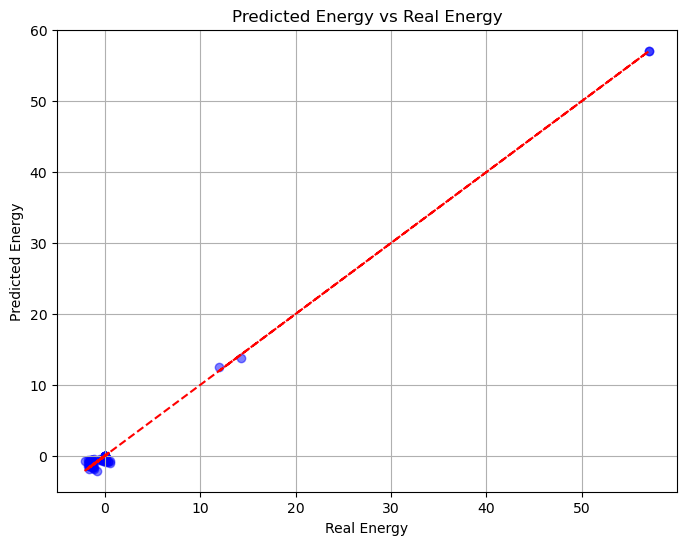

In [133]:
import matplotlib.pyplot as plt

# Prepare lists to store predicted and real energy values
predicted_energies = []
real_energies = []

# Pass the test data through the trained GNN model to obtain predictions
for node_features, adj_matrix, target_energies in test_data_list:
    test_outputs = gnn(node_features, adj_matrix)
    predicted_energies.extend(test_outputs.detach().numpy().flatten())  # Convert torch tensor to numpy array
    real_energies.extend(target_energies.numpy())

# Plot predicted energy vs real energy
plt.figure(figsize=(8, 6))
plt.scatter(real_energies, predicted_energies, color='blue', alpha=0.5)
plt.plot(real_energies, real_energies, color='red', linestyle='--')  # Plot y = x line for reference
plt.xlabel('Real Energy')
plt.ylabel('Predicted Energy')
plt.title('Predicted Energy vs Real Energy')
plt.grid(True)
plt.show()


In [129]:
#function to calculate the energy based on your trained model
def calculate_total_energy(atoms, gnn_model, cutoff=5.0):
    # Step 1: Convert Atoms object into node features and adjacency matrix
    node_features, adj_matrix = build_graph(atoms, cutoff=cutoff)
    
    # Step 2: Pass node features and adjacency matrix through the GNN model
    predicted_energies = gnn_model(node_features, adj_matrix)
    
    # Step 3: Sum up the predicted energies to get the total energy
    total_energy = torch.sum(predicted_energies).item()
    
    return total_energy

# Example usage:
gnn_model = gnn
total_energy = calculate_total_energy(atoms, gnn)
print("Total energy:", total_energy)


Total energy: 140.507568359375


In [130]:
from ase.collections import g2


In [131]:
print(g2.names)  
"C6 H15 N2 O2" 

['PH3', 'P2', 'CH3CHO', 'H2COH', 'CS', 'OCHCHO', 'C3H9C', 'CH3COF', 'CH3CH2OCH3', 'HCOOH', 'HCCl3', 'HOCl', 'H2', 'SH2', 'C2H2', 'C4H4NH', 'CH3SCH3', 'SiH2_s3B1d', 'CH3SH', 'CH3CO', 'CO', 'ClF3', 'SiH4', 'C2H6CHOH', 'CH2NHCH2', 'isobutene', 'HCO', 'bicyclobutane', 'LiF', 'Si', 'C2H6', 'CN', 'ClNO', 'S', 'SiF4', 'H3CNH2', 'methylenecyclopropane', 'CH3CH2OH', 'F', 'NaCl', 'CH3Cl', 'CH3SiH3', 'AlF3', 'C2H3', 'ClF', 'PF3', 'PH2', 'CH3CN', 'cyclobutene', 'CH3ONO', 'SiH3', 'C3H6_D3h', 'CO2', 'NO', 'trans-butane', 'H2CCHCl', 'LiH', 'NH2', 'CH', 'CH2OCH2', 'C6H6', 'CH3CONH2', 'cyclobutane', 'H2CCHCN', 'butadiene', 'C', 'H2CO', 'CH3COOH', 'HCF3', 'CH3S', 'CS2', 'SiH2_s1A1d', 'C4H4S', 'N2H4', 'OH', 'CH3OCH3', 'C5H5N', 'H2O', 'HCl', 'CH2_s1A1d', 'CH3CH2SH', 'CH3NO2', 'Cl', 'Be', 'BCl3', 'C4H4O', 'Al', 'CH3O', 'CH3OH', 'C3H7Cl', 'isobutane', 'Na', 'CCl4', 'CH3CH2O', 'H2CCHF', 'C3H7', 'CH3', 'O3', 'P', 'C2H4', 'NCCN', 'S2', 'AlCl3', 'SiCl4', 'SiO', 'C3H4_D2d', 'H', 'COF2', '2-butyne', 'C2H5', 'BF3'

'C6 H15 N2 O2'

In [ ]:
from ase.build import molecule
atoms = read('C:/Users/cuau_/Downloads/protein.xyz')

In [ ]:
atoms